In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
import xgboost as xgb
from sklearn.pipeline import Pipeline

import os
import pickle

ROOT = "C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/BNP Credit Card Fraud Detection/fraud_detection/"
os.chdir(ROOT)

In [2]:
MODEL_RANK = -1
EVAL_DATA = os.path.join(ROOT, 'data/processed/model_validation_data.csv')

# Show models that are in the models directory that has "16" in its name
active_models = [model for model in os.listdir(os.path.join("models")) if '16' in model]
print(active_models)
MODEL_PATH = active_models[MODEL_RANK]

['01-Anas-XGBTuned-16_Feb_2024_06_48_04.pickle', '01-Anas-XGBTuned-16_Feb_2024_06_52_44.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_10_22.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_12_25.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_14_13.pickle']


In [3]:
# Load the model
with open(os.path.join(ROOT, "models", MODEL_PATH), 'rb') as file:
    model_args = pickle.load(file)

- Model Template

In [ ]:
output = {"model": model,
          "model_params_explicit": params if PARAMS_FILE else None,
          "pipe": pipe,
          "model_name": "XGBoost",
          "prediction_matrix_type": "xgb.DMatrix",
          "y_true_train": y_true_train,
          "y_pred_train": y_pred_train,
          "y_true_test": y_true_test,
          "y_pred_test": y_pred_test,}

pickle.dump(output, open(OUTPUT_FILE_NAME, "wb"))

- Parser

In [4]:
# Unpack the model arguments
# Maybe include the model name (with date) in the model_args dictionary
class Model():
    def __init__(self, model_args):
        self.model = model_args['model']
        self.pipe = model_args['pipe']
        self.model_name = model_args['model_name']
        self.prediction_matrix_type = model_args['prediction_matrix_type']
        self.y_true_train = model_args['y_true_train']
        self.y_pred_train = model_args['y_pred_train']
        self.y_true_test = model_args['y_true_test']
        self.y_pred_test = model_args['y_pred_test']
        self.y_pred_valid = None
        self.y_true_valid = None

    def load_predict_eval(self, EVAL_DATA):
        eval_data = pd.read_csv(EVAL_DATA)
        X_eval = eval_data.drop('fraud_flag', axis=1)
        y_eval = eval_data['fraud_flag']

        X_eval = self.pipe.transform(X_eval)
        if self.prediction_matrix_type == 'xgb.DMatrix':
            X_eval = xgb.DMatrix(X_eval)

        self.y_pred_valid = self.model.predict(X_eval)
        self.y_true_valid = y_eval

model_XGB = Model(model_args)
model_XGB.load_predict_eval(EVAL_DATA)

C:\Users\mabid\AppData\Local\Temp\ipykernel_29328\408104532.py:17: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_data = pd.read_csv(EVAL_DATA)


In [5]:
from typing import Tuple, List

class GenerateReport():
    def __init__(self, model: Model, thresholds: List[float] = [0.01, 0.1]) -> None:
        self.model = model
        self.thresholds = thresholds

    def modified_confusion_matrix(self, true_labels, pred_labels, threshold: float, ax=None, model_name: str = "model") -> None:
        pred_labels = (pred_labels > threshold).astype(int)
        cm = confusion_matrix(pred_labels, true_labels)

        scores_df = pd.DataFrame(precision_recall_fscore_support(pred_labels, true_labels)).T
        scores_df.columns = ["precision", "recall", "fscore", "support"]
        scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
        scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
        overall_accuracy = "{:.2%}".format(accuracy_score(pred_labels, true_labels))

        res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis=1)
        res = pd.concat([res, scores_df['precision'].to_frame().T], axis=0)

        heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8}, ax=ax)

        ax.set_xticklabels([str(i) for i in range(2)] + ["Rate (%)"])
        ax.set_yticklabels([str(i) for i in range(2)] + ["Rate (%)"])
        ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)

        ax.set_ylabel('Predicted Labels')
        ax.set_title(f"{model_name} Model\nThreshold: {threshold}\nTrue Labels", multialignment='center')
        ax.set_frame_on(False)

    def plot_precision_recall_curve(self, true_labels, pred_labels, ax=None, model_name: str = "model") -> None:
        precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
        map = average_precision_score(true_labels, pred_labels)
        
        ax.plot(recall, precision, label='Precision-Recall Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Average Precision Score ({model_name}): {map:.4f}')
        ax.legend()
        ax.plot([0, 1], [1, 0], linestyle='--', label='Baseline')

    def generate_report(self):
        fig, ax = plt.subplots(3, 3, figsize=(22, 18))

        for i, threshold in enumerate(self.thresholds):
            ax_i = ax[0, i]
            self.modified_confusion_matrix(self.model.y_true_train, self.model.y_pred_train, threshold, ax_i, self.model.model_name)
        ax_pr = ax[0, -1]
        self.plot_precision_recall_curve(self.model.y_true_train, self.model.y_pred_train, ax_pr, self.model.model_name)

        for i, threshold in enumerate(self.thresholds):
            ax_i = ax[1, i]
            self.modified_confusion_matrix(self.model.y_true_test, self.model.y_pred_test, threshold, ax_i, self.model.model_name)
        ax_pr = ax[1, -1]
        self.plot_precision_recall_curve(self.model.y_true_test, self.model.y_pred_test, ax_pr, self.model.model_name)

        for i, threshold in enumerate(self.thresholds):
            ax_i = ax[2, i]
            self.modified_confusion_matrix(self.model.y_true_valid, self.model.y_pred_valid, threshold, ax_i, self.model.model_name)
        ax_pr = ax[2, -1]
        self.plot_precision_recall_curve(self.model.y_true_valid, self.model.y_pred_valid, ax_pr, self.model.model_name)
        return ax

array([[<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.3027'}, xlabel='Recall', ylabel='Precision'>],
       [<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.1804'}, xlabel='Recall', ylabel='Precision'>],
       [<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.1803'}, xlabel='Recall', ylabel='Precision'>]],
   

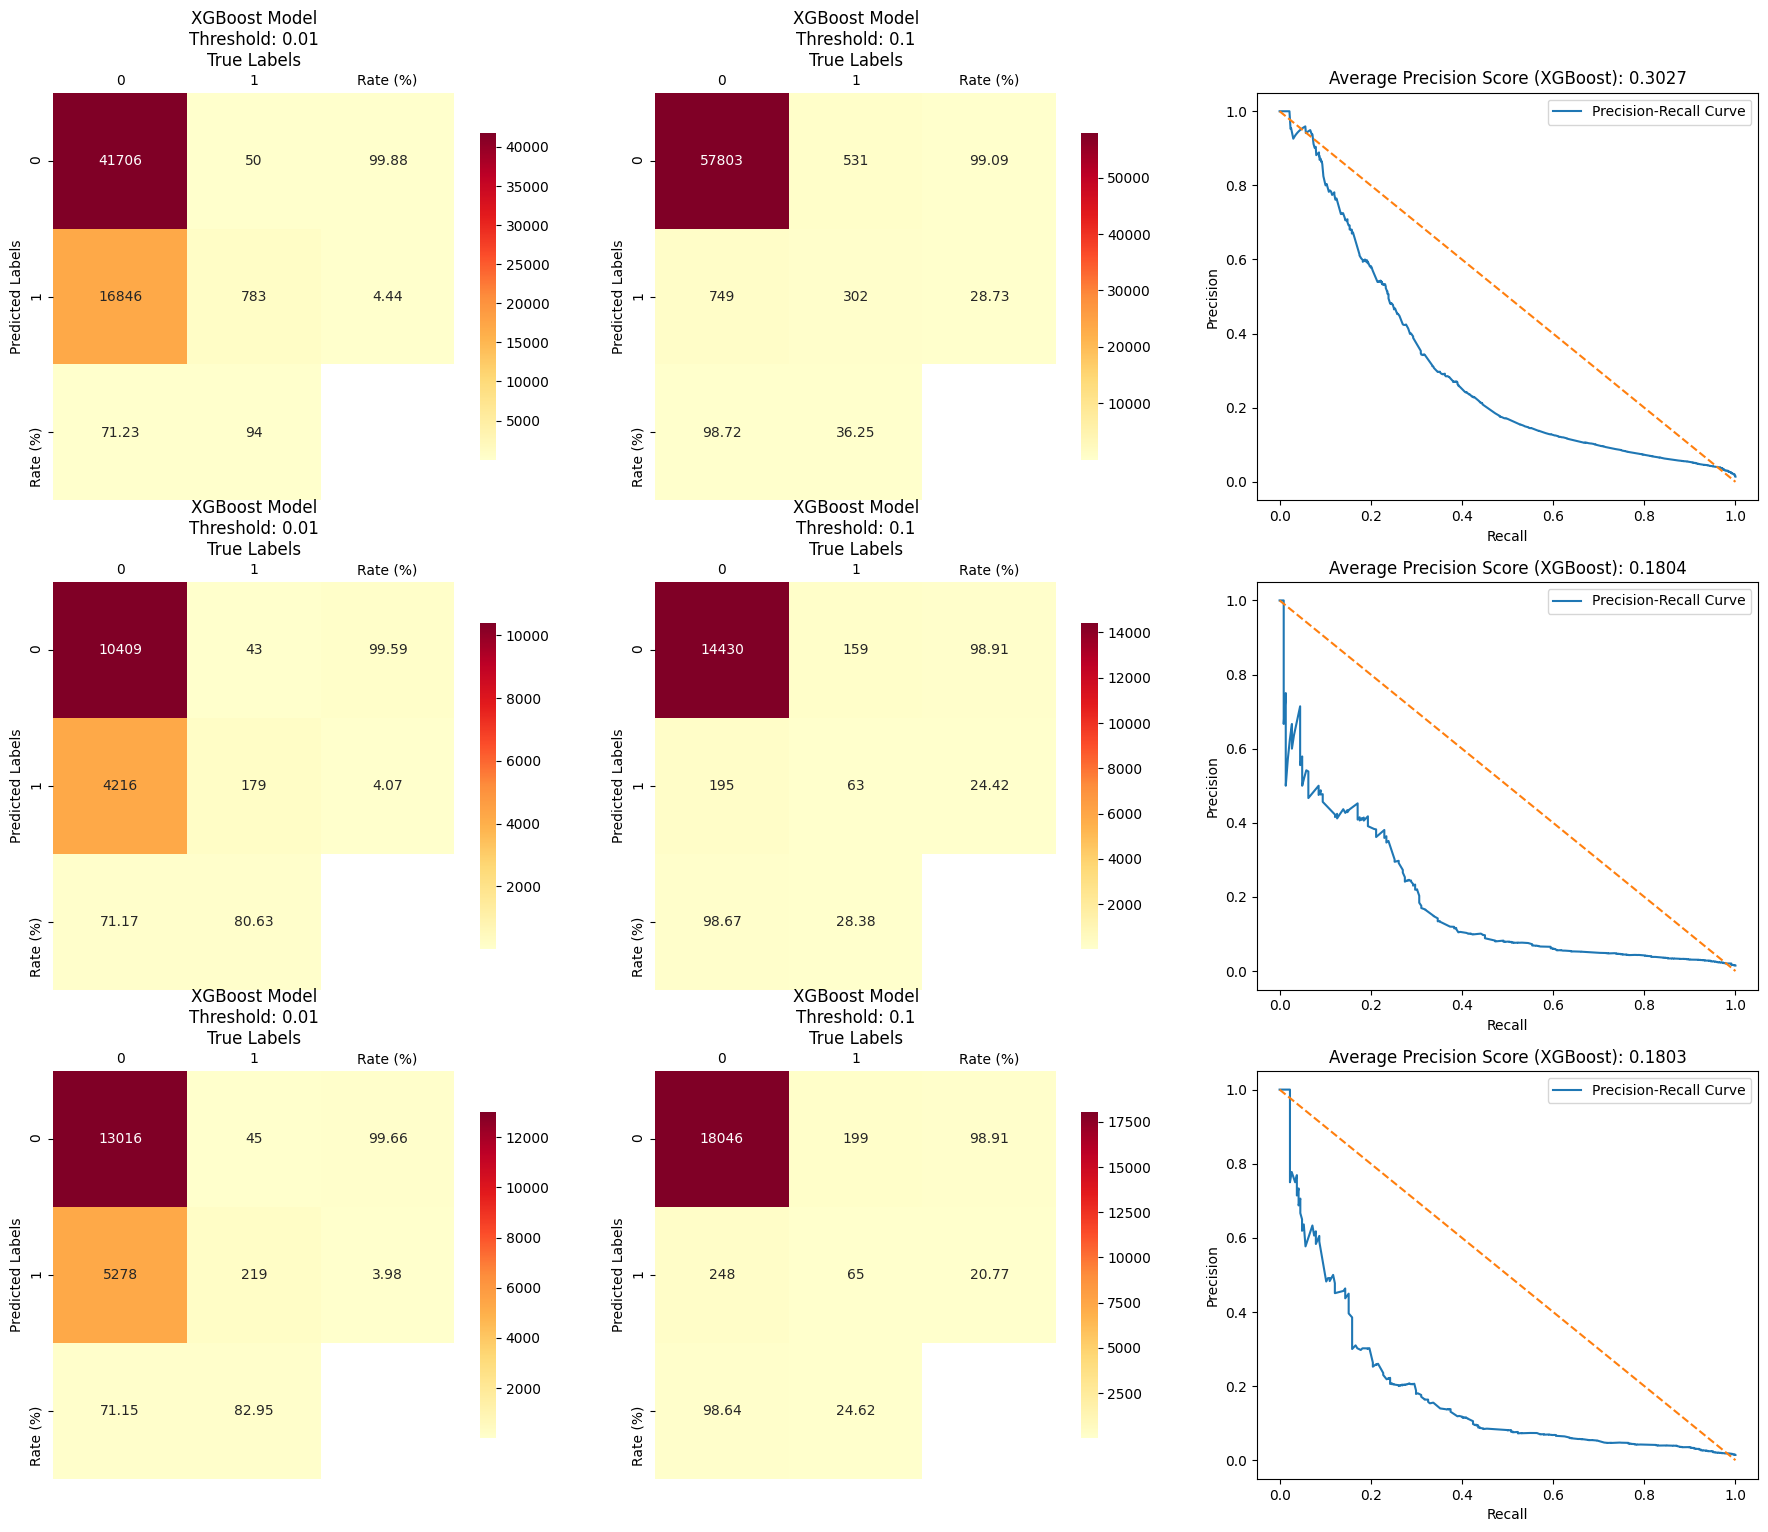

In [6]:
report = GenerateReport(model_XGB)
report.generate_report()

## Testing the modules

C:\Users\mabid\OneDrive\Desktop\Projects - Ongoing\BNP Credit Card Fraud Detection\fraud_detection\src\visualization\evaluation_report.py:54: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_data = pd.read_csv(EVAL_DATA)


array([[<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.3027'}, xlabel='Recall', ylabel='Precision'>],
       [<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.1804'}, xlabel='Recall', ylabel='Precision'>],
       [<Axes: title={'center': 'XGBoost Model\nThreshold: 0.01\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'XGBoost Model\nThreshold: 0.1\nTrue Labels'}, ylabel='Predicted Labels'>,
        <Axes: title={'center': 'Average Precision Score (XGBoost): 0.1803'}, xlabel='Recall', ylabel='Precision'>]],
   

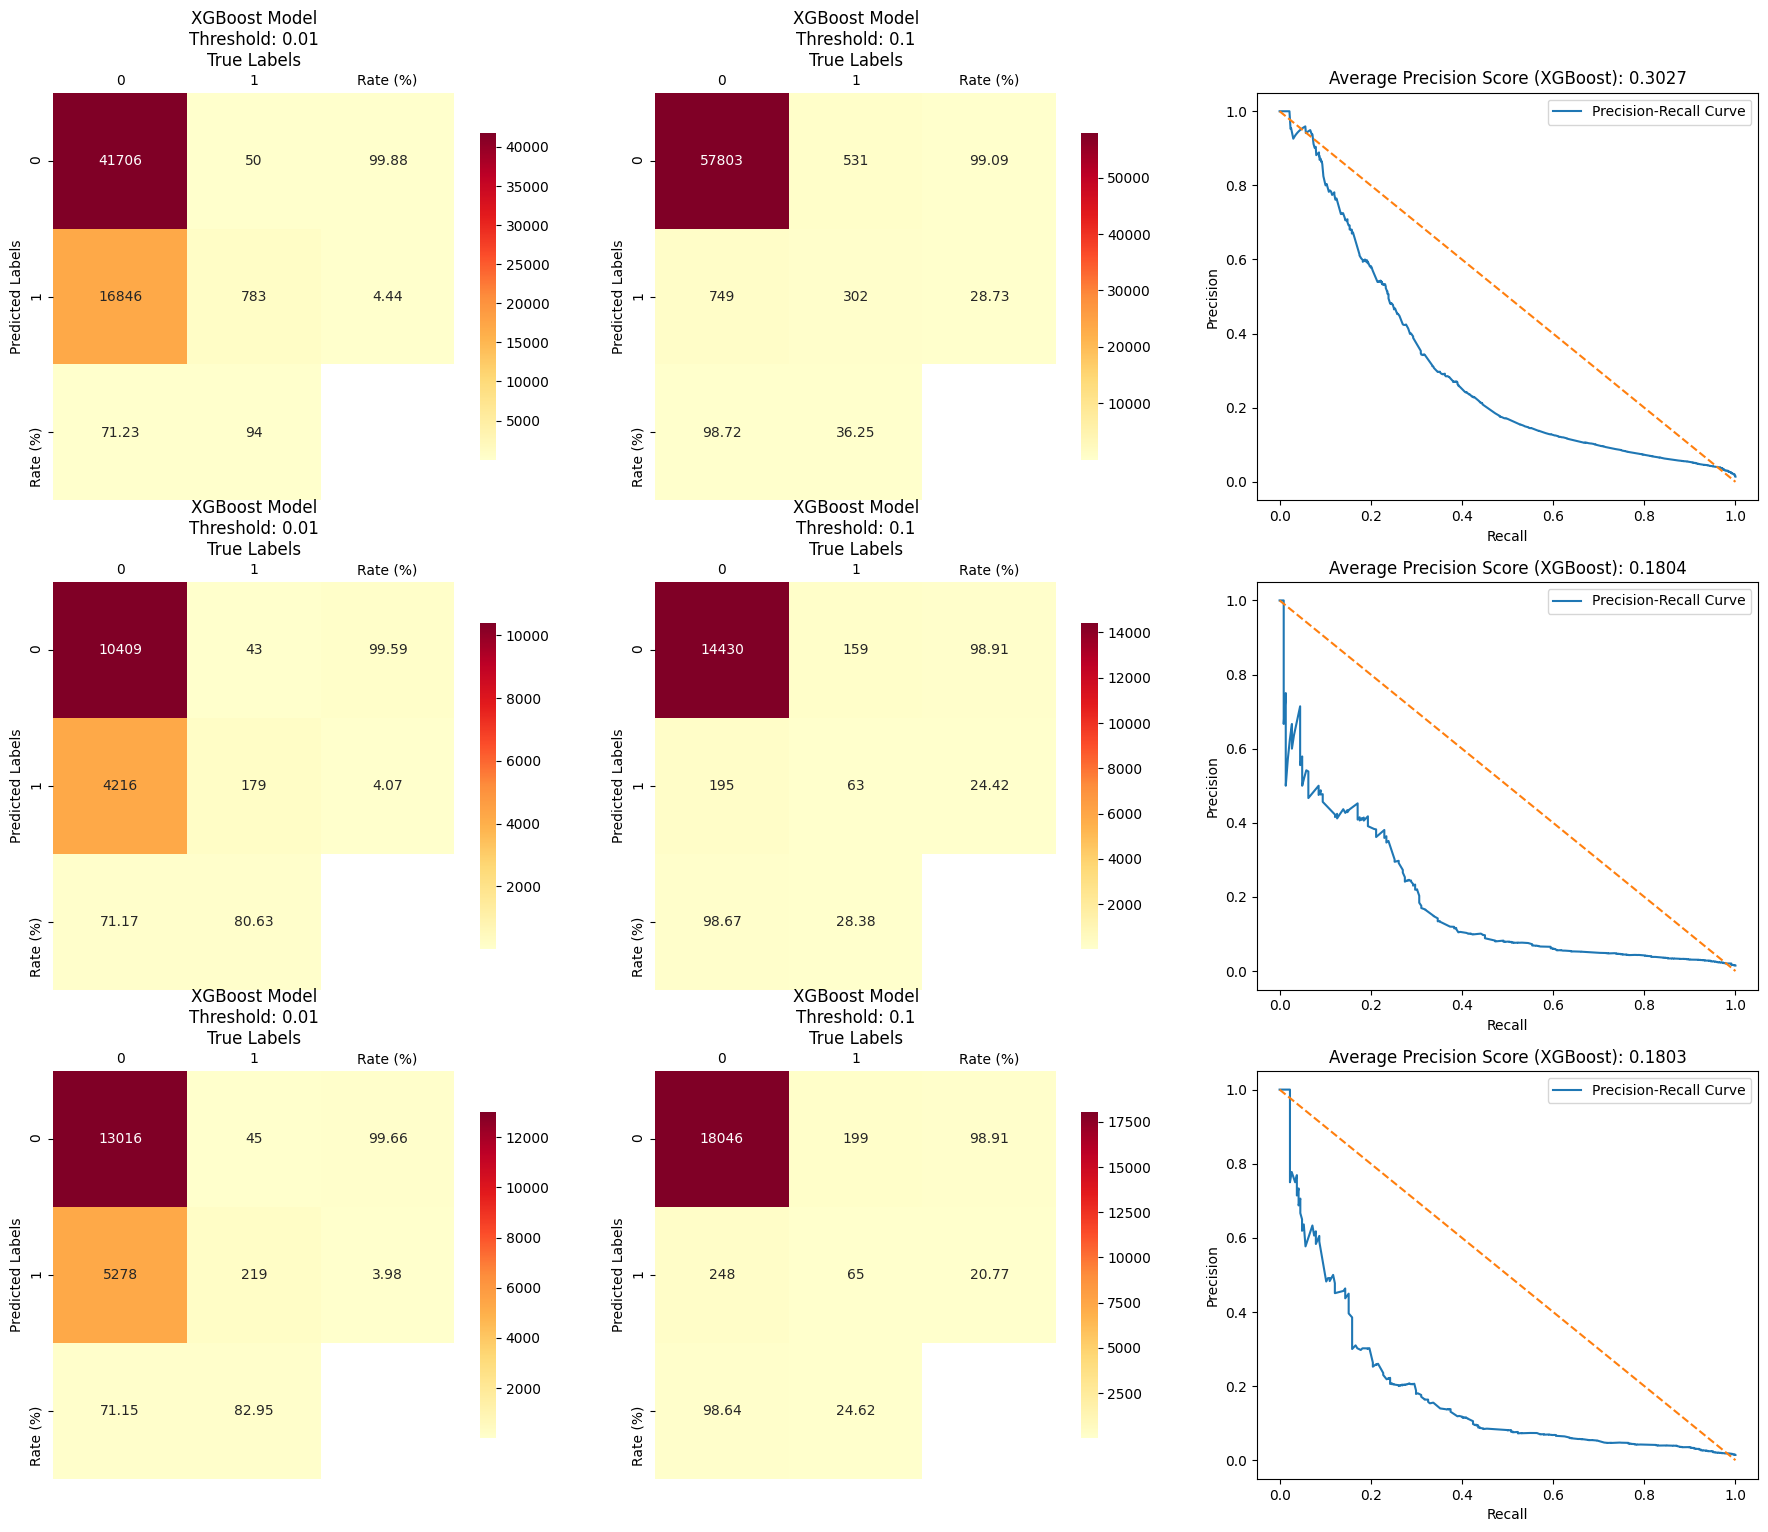

In [10]:
from src.visualization.evaluation_report import GenerateReport, Model

sbh = Model(model_args)
sbh.load_predict_eval(EVAL_DATA)

report = GenerateReport(sbh)
report.generate_report()

In [7]:
class GenerateReport():
    def __init__(self, model, thresholds=[0.01, 0.05, 0.1]):
        self.model = model
        self.thresholds = [0.01, 0.05, 0.1]
        self.fig, self.ax = plt.subplots(1, 4, figsize=(20, 4))

    def modified_confusion_matrix(self, true_labels, pred_labels, ax, model_name: str = "model", threshold: float = 0.5):
        pred_labels = (pred_labels > threshold).astype(int)
        cm = confusion_matrix(pred_labels, true_labels)
        scores_df = pd.DataFrame(precision_recall_fscore_support(pred_labels, true_labels)).T
        scores_df.columns = ["precision", "recall", "fscore", "support"]
        scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
        scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
        overall_accuracy = "{:.2%}".format(accuracy_score(pred_labels, true_labels))
        res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis=1)
        res = pd.concat([res, scores_df['precision'].to_frame().T], axis=0)
        heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8}, ax=ax)
        ax.set_xticklabels([str(i) for i in range(2)] + ["Rate (%)"])
        ax.set_yticklabels([str(i) for i in range(2)] + ["Rate (%)"])
        ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
        ax.set_ylabel('Predicted Labels')
        ax.set_title(f"Confusion Matrix for the {model_name} Model " + f"({threshold})" + '\n' + '\n' + r"True Labels", multialignment='center')
        ax.set_frame_on(False)

    def plot_precision_recall_curve(self, true_labels, pred_labels, ax=None, model_name: str = "model"):
        precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
        map = average_precision_score(true_labels, pred_labels)
        ax.plot(recall, precision, label='Precision-Recall Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Average Precision Score ({model_name}): {map:.4f}')
        ax.legend()
        ax.plot([0, 1], [1, 0], linestyle='--', label='Baseline')
        plt.show()

    def generate_report(self):
        fig, ax = plt.subplots(1, 4, figsize=(20, 4))
        for i, threshold in enumerate(self.thresholds):
            ax_i = ax[i]
            self.modified_confusion_matrix(self.model.y_true_train, self.model.y_pred_train, self.model.model_name, threshold, ax_i)
        ax_pr = ax[-1]
        self.plot_precision_recall_curve(self.model.y_true_train, self.model.y_pred_train, self.model.model_name, ax_pr)
        plt.tight_layout()
        plt.show()



def modified_confusion_matrix(true_labels, pred_labels, ax, model_name: str = "model", threshold: float = 0.5):

    pred_labels = (pred_labels > threshold).astype(int)

    cm = confusion_matrix(pred_labels, true_labels)

    scores_df = pd.DataFrame(precision_recall_fscore_support(pred_labels, true_labels)).T
    scores_df.columns = ["precision", "recall", "fscore", "support"]
    scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
    scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
    overall_accuracy = "{:.2%}".format(accuracy_score(pred_labels, true_labels))
    res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis=1)
    res = pd.concat([res, scores_df['precision'].to_frame().T], axis=0)

    heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8}, ax=ax)
    ax.set_xticklabels([str(i) for i in range(2)] + ["Rate (%)"])
    ax.set_yticklabels([str(i) for i in range(2)] + ["Rate (%)"])
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    ax.set_ylabel('Predicted Labels')
    ax.set_title(f"Confusion Matrix for the {model_name} Model " + f"({threshold})" + '\n' + '\n' + r"True Labels", multialignment='center')
    ax.set_frame_on(False)

def plot_precision_recall_curve(true_labels, pred_labels, ax=None, model_name: str = "model"):
    precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
    map = average_precision_score(true_labels, pred_labels)

    ax.plot(recall, precision, label='Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Average Precision Score ({model_name}): {map:.4f}')
    ax.legend()
    ax.plot([0, 1], [1, 0], linestyle='--', label='Baseline')

    plt.show()

def generate_report():
    thresholds = [0.01, 0.05, 0.1]
    print(f'Evaluation Metrics for {model_XGB.model_name}')
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    for i, threshold in enumerate(thresholds):
        ax_i = ax[i]
        modified_confusion_matrix(model_XGB.y_true_train, model_XGB.y_pred_train, model_XGB.model_name, threshold, ax_i)
    ax_pr = ax[-1]
    plot_precision_recall_curve(model_XGB.y_true_train, model_XGB.y_pred_train, model_XGB.model_name, ax_pr)
    plt.tight_layout()
    plt.show()


In [41]:
model_XGB.y_true_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Evaluation Metrics for XGBoost


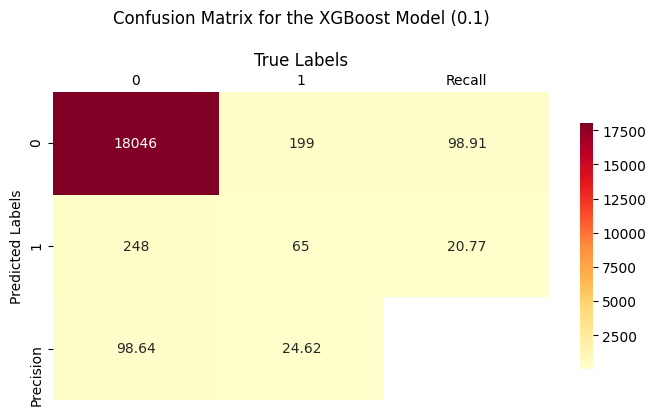

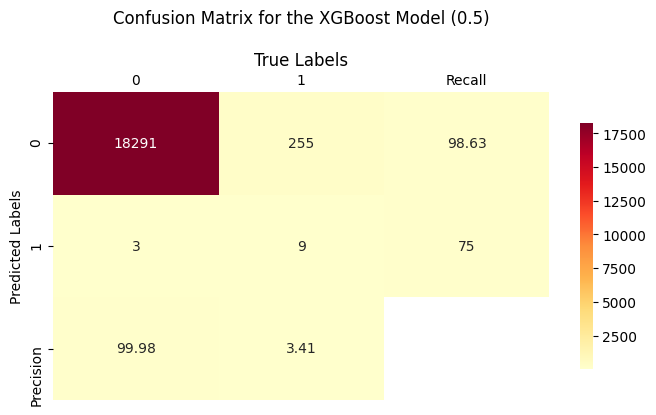

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


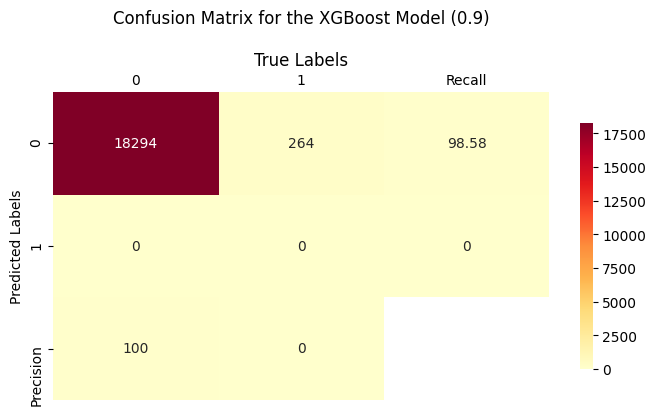

In [ ]:
# Print the evaluation metrics for training set
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc
thresholds = [.1, .5, .9]
print(f'Evaluation Metrics for {model_XGB.model_name}')

#Confusion Matrix for each threshold
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
for threshold in thresholds:
    modified_confusion_matrix(model_XGB.y_pred_valid, model_XGB.y_true_valid, model_XGB.model_name, threshold)

In [26]:
model_XGB.y_pred_valid = model_XGB.model.predict(eval_data)

In [5]:
eval_data = pd.read_csv(EVAL_DATA)
eval_data

C:\Users\mabid\AppData\Local\Temp\ipykernel_21872\2534171464.py:1: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_data = pd.read_csv(EVAL_DATA)


,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items,fraud_flag
0,38100,TELEVISIONS HOME CINEMA,TELEVISIONS HOME CINEMA,AUDIO ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
1,13409,BEDROOM FURNITURE,BEDROOM FURNITURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
2,56447,TELEVISIONS HOME CINEMA,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
3,94627,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
4,11531,COMPUTERS,COMPUTER SOFTWARE,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18553,16785,"TELEPHONES, FAX MACHINES & TWO-WAY RADIOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
18554,11514,COMPUTER PERIPHERALS & ACCESSORIES,WARRANTY,AUDIO ACCESSORIES,WARRANTY,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0
18555,26807,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,BAGS CARRY CASES,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0
18556,84360,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
